## Benford's Law Analysis

#### [Benford's Law](https://en.wikipedia.org/wiki/Benford's_law) states that in many naturally occurring collections of numbers, the leading significant digit is likely to be small. For example, in sets that obey the law, the number 1 appears as the leading significant digit about 30% of the time, while 9 appears as the leading significant digit less than 5% of the time. If the digits were distributed uniformly, they would each occur about 11.1% of the time.

#### The law has applications in determining if a set of transactions are fraudulent since a person forging transactions would likely ensure the numbers forged are random.  I'm interested in seeing how The City of Scottsdale Vendor Payments dataset compares with the first digit percentages outlined by Benford's Law.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import seaborn as sns

vendor_payments = pd.read_csv('ct_VendorPayments.csv')

In [2]:
vendor_payments.head()

,PaymentDate,VendorName,PaymentAmount,Fund,FundDescription,Center,CenterName,Account,AccountName,FiscalYear,AccountingPeriod
0,8/14/2017 0:00,A TO Z EQUIPMENT RENTAL & SALES,1021.38,200,TRANSPORTATION,20860,TRAFFIC SIGNALS,53790,"MAT TO MAINT & REPAIR MACH, EQUIP",2018,2
1,8/14/2017 0:00,AIMS PVIC,380.00,100,GENERAL,25411,IRRIGATION REPAIR,52360,"MAINT - MACHINERY, EQUIP & AUTOS",2018,2
2,8/14/2017 0:00,AIMS PVIC,2125.00,200,TRANSPORTATION,20810,GRADING AND DRAINAGE,52390,MISC MAINTENANCE AND REPAIR,2018,2
3,8/14/2017 0:00,AIMS PVIC,15658.03,603,WATER RECLAMATION,29321,SEWER SYSTEM,52190,OTHER PROFESSIONAL SERVICES,2018,2
4,8/14/2017 0:00,ALL CITY TOWING,583.00,700,FLEET MANAGEMENT,20706,FLEET MANAGEMENT OPERATIONS,52360,"MAINT - MACHINERY, EQUIP & AUTOS",2018,2


In [3]:
vendor_payments.dtypes

PaymentDate          object
VendorName           object
PaymentAmount       float64
Fund                  int64
FundDescription      object
Center               object
CenterName           object
Account               int64
AccountName          object
FiscalYear            int64
AccountingPeriod      int64
dtype: object

In [32]:
# extract leading digit from payment amounts
vendor_payments['Leading_Digit'] = vendor_payments['PaymentAmount'].apply(lambda x: str(x)[0])

vendor_payments.head()

,PaymentDate,VendorName,PaymentAmount,Fund,FundDescription,Center,CenterName,Account,AccountName,FiscalYear,AccountingPeriod,Leading_Digit
0,8/14/2017 0:00,A TO Z EQUIPMENT RENTAL & SALES,1021.38,200,TRANSPORTATION,20860,TRAFFIC SIGNALS,53790,"MAT TO MAINT & REPAIR MACH, EQUIP",2018,2,1
1,8/14/2017 0:00,AIMS PVIC,380.00,100,GENERAL,25411,IRRIGATION REPAIR,52360,"MAINT - MACHINERY, EQUIP & AUTOS",2018,2,3
2,8/14/2017 0:00,AIMS PVIC,2125.00,200,TRANSPORTATION,20810,GRADING AND DRAINAGE,52390,MISC MAINTENANCE AND REPAIR,2018,2,2
3,8/14/2017 0:00,AIMS PVIC,15658.03,603,WATER RECLAMATION,29321,SEWER SYSTEM,52190,OTHER PROFESSIONAL SERVICES,2018,2,1
4,8/14/2017 0:00,ALL CITY TOWING,583.00,700,FLEET MANAGEMENT,20706,FLEET MANAGEMENT OPERATIONS,52360,"MAINT - MACHINERY, EQUIP & AUTOS",2018,2,5


In [297]:
leading_digit_percent = vendor_payments \
    .groupby('Leading_Digit')['Leading_Digit'] \
    .count() \
    .sort_values(ascending=False) \
    .to_frame()

# rename dataframe column to be more clear
leading_digit_percent.rename(columns={'Leading_Digit':'Leading_Digit_Count'},inplace=True)

leading_digit_percent

# why are there negative and zero numbers?
# could these represent refunds?

,Leading_Digit_Count
Leading_Digit,
1,6916
2,4063
3,3129
4,2312
5,1873
6,1545
7,1348
8,1198
9,1116


In [298]:
# remove digits beyond 9
leading_digit_percent.drop(leading_digit_percent.index[9:11], inplace=True)
 
leading_digit_percent.index

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='object', name='Leading_Digit')

In [260]:
# how many vendor payments are in the dataset?
len(vendor_payments.index)

23612

In [330]:
# how many vendor payments with leading digits between 1-9?
leading_digit_percent.iloc[:,0].sum()

23500

In [326]:
# form percent attribute to the dataframe
leading_digit_percent['Scottsdale_Percent'] = leading_digit_percent.iloc[:,0] \
    .div(leading_digit_percent \
         .iloc[:,0] \
         .sum()/100) \
         .round(1)

In [329]:
# convert index to type int so that I can use this to merge below
leading_digit_percent.index = leading_digit_percent.index.astype(int)
leading_digit_percent.index

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64', name='Leading_Digit')

In [325]:
benfords_law = pd.DataFrame(
    {'Leading_Digit':[1,2,3,4,5,6,7,8,9],
     'Benfords_Percent':[30.1,17.60,12.50,9.70,7.90,6.70,5.80,5.10,4.60]}
    )

benfords_law.index = benfords_law['Leading_Digit']
benfords_law

,Leading_Digit,Benfords_Percent
Leading_Digit,,
1,1,30.1
2,2,17.6
3,3,12.5
4,4,9.7
5,5,7.9
6,6,6.7
7,7,5.8
8,8,5.1
9,9,4.6


In [306]:
# join datasets of City of Scottsdale vendor payments leading digit percents with Benfords Law leading percents
scottsdale_benfords = pd \
    .merge(leading_digit_percent.head(9), \
           benfords_law, \
           left_index=True, \
           right_index=True)

scottsdale_benfords

,Leading_Digit_Count,Scottsdale_Percent,Leading_Digit,Benfords_Percent
Leading_Digit,,,,
1,6916,29.4,1,30.1
2,4063,17.3,2,17.6
3,3129,13.3,3,12.5
4,2312,9.8,4,9.7
5,1873,8.0,5,7.9
6,1545,6.6,6,6.7
7,1348,5.7,7,5.8
8,1198,5.1,8,5.1
9,1116,4.7,9,4.6


In [307]:
# shape data into long format to be able to graph
scottsdale_benfords_long = pd.melt(scottsdale_benfords, \
                                      id_vars='Leading_Digit', \
                                      value_vars=['Scottsdale_Percent','Benfords_Percent'])
scottsdale_benfords_long

,Leading_Digit,variable,value
0,1,Scottsdale_Percent,29.4
1,2,Scottsdale_Percent,17.3
2,3,Scottsdale_Percent,13.3
3,4,Scottsdale_Percent,9.8
4,5,Scottsdale_Percent,8.0
5,6,Scottsdale_Percent,6.6
6,7,Scottsdale_Percent,5.7
7,8,Scottsdale_Percent,5.1
8,9,Scottsdale_Percent,4.7
9,1,Benfords_Percent,30.1


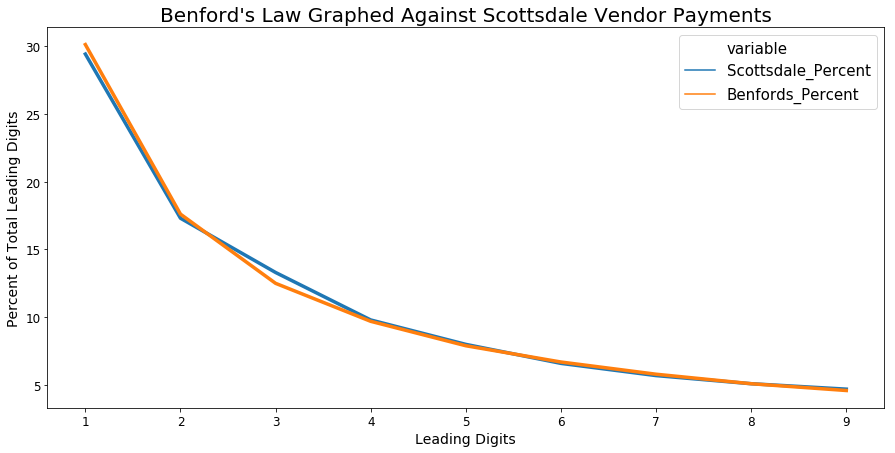

In [323]:
plt.rcParams["figure.figsize"] = [15, 7]

ax = sns.lineplot(x="Leading_Digit", \
                  y="value", \
                  hue="variable", \
                  data=scottsdale_benfords_long, \
                  linewidth=3.5)

plt.title("Benford's Law Graphed Against Scottsdale Vendor Payments",fontsize=20)
plt.xlabel("Leading Digits",fontsize=14)
plt.ylabel("Percent of Total Leading Digits",fontsize=14)
plt.tick_params(labelsize=12)
plt.legend(fontsize=15)

ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator())

### Results: No evidence of fraud when taking all vendor payments in aggregate.  The City of Scottsdale Vendor Payments track almost exactly with what Benford's Law would predict.

### Next steps: apply Benford's Law to each vendor with over 20 payments for the year.  I'm interested in seeing if a higher granularity of analysis on specific vendors causes specific vendors to surface.